<a href="https://colab.research.google.com/github/poomshift/PromptAlchemist_SDXL_Lightning_colab/blob/main/PromptAlchemist_SDXL_Lightning_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

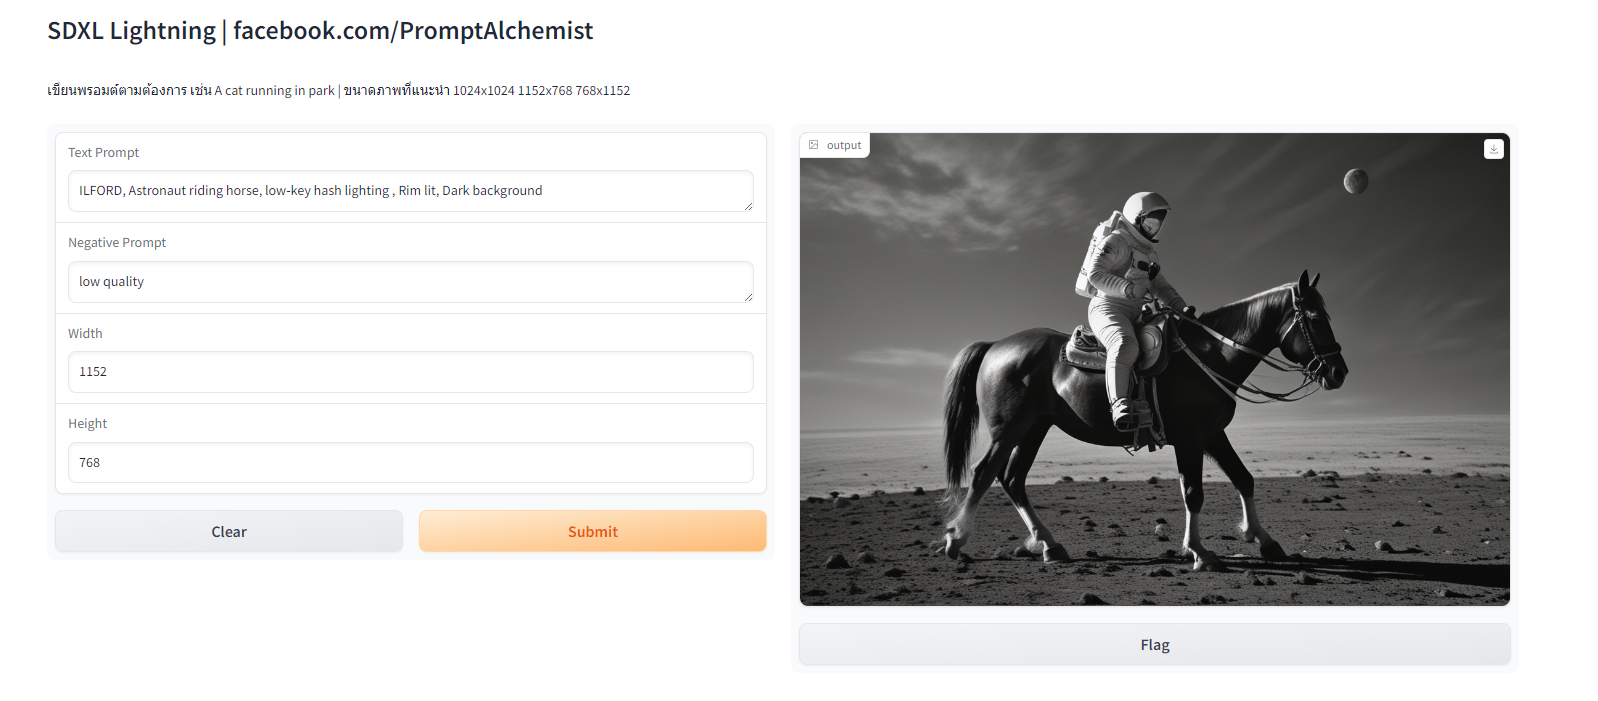

Colab Notebook นี้สร้างเพื่อใช้งาน SDXL-Lightning อย่างรวดเร็ว

ใช้เวลา generate ประมาณ 5-6 วินาที ด้วยขนาดภาพ 1024x1024

**Google Colab Free ก็ใช้งานได้!!**

เป็นอีกหนึ่งโปรเจคที่ผมทดลองใช้ Google's Gemini ในการช่วยเขียน App

ติดตามอัพเดทเกี่ยวกับเทคโนโลยี Ai ที่ [Facebook/promptalchemist](https://facebook.com/PromptAlchemist)

Colab สำหรับ Stable Diffusion WebUI [>>คลิก<<](https://colab.research.google.com/github/poomshift/PromptAlchemist_SD_Webui_Colab/blob/main/PromptAlchemist_SD_Webui_Colab.ipynb#scrollTo=1F-zYI2-Uo0a)

In [ ]:
#@markdown # 1. ติดตั้ง Dependencies ก่อน
from IPython.display import clear_output
from IPython.display import Javascript
import ipywidgets as widgets
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 200})'''))
def inf(msg, style, wdth): inf = widgets.Button(description=msg, disabled=True, button_style=style, layout=widgets.Layout(min_width=wdth));display(inf)

%env TF_CPP_MIN_LOG_LEVEL=1
!wget https://github.com/camenduru/gperftools/releases/download/v1.0/libtcmalloc_minimal.so.4 -O /content/libtcmalloc_minimal.so.4
%env LD_PRELOAD=/content/libtcmalloc_minimal.so.4
!pip install gradio diffusers accelerate torch huggingface_hub

clear_output()
inf('\u2714 Done','success', '50px')

In [ ]:
#@markdown # 2. Run โปรแกรม
import gradio as gr
import torch
from diffusers import StableDiffusionXLPipeline, UNet2DConditionModel, EulerDiscreteScheduler
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file
from IPython.display import clear_output
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 1000})'''))

base = "stabilityai/stable-diffusion-xl-base-1.0"
repo = "ByteDance/SDXL-Lightning"
ckpt = "sdxl_lightning_4step_unet.safetensors"

# Load model (this will be done once when the app starts).
unet = UNet2DConditionModel.from_config(base, subfolder="unet").to("cuda", torch.float16)
unet.load_state_dict(load_file(hf_hub_download(repo, ckpt), device="cuda"))
pipe = StableDiffusionXLPipeline.from_pretrained(base, unet=unet, torch_dtype=torch.float16, variant="fp16").to("cuda")
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")
clear_output()

def generate_image(prompt, negative_prompt, width, height):
  try:
    image = pipe(
       prompt=prompt,
       negative_prompt=negative_prompt,
       width=width,
       height=height,
       num_inference_steps=4,
       guidance_scale=0
     ).images[0]
    return image
  except Exception as e:
    return f"Error: {e}"

interface = gr.Interface(
  fn=generate_image,
  inputs=[
    gr.Textbox(label="Text Prompt", value="ILFORD, Astronaut riding horse, low-key hash lighting , Rim lit, Dark background, film grain"),
    gr.Textbox(label="Negative Prompt"),
    gr.Number(label="Width", value=1024),
    gr.Number(label="Height", value=1024)
  ],
  outputs="image",
  title="SDXL Lightning | facebook.com/PromptAlchemist",
  description="เขียนพรอมต์ตามต้องการ เช่น A cat running in park | ขนาดภาพที่แนะนำ 1024x1024 1152x768 768x1152"
)
interface.launch()